## *Multi-Layer Perceptron* (Perceptron de Muitas Camadas)

# Agora vamos resolver um problema prático e bastante desafiador, para verificar o real poder das redes neurais artificiais. Como de costume, vamos primeiro investigar a base de dados que utilizaremos. Dê uma olhada:
  
https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/curitibadiario.csv

In [1]:
import pandas as pd
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/curitibadiario.csv",
                      skiprows = 16, sep=';')


In [0]:
#Visualizando cabeçalho dos dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83842,01/01/1980,0,NaN,24.6,NaN,11.7,7.4,15.94,69.25,3.366667,NaN
1,83842,01/01/1980,1200,0.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2,83842,02/01/1980,0,NaN,25.0,NaN,8.1,1.9,16.52,76.75,1.700000,NaN
3,83842,02/01/1980,1200,0.0,NaN,11.7,NaN,NaN,NaN,NaN,NaN,NaN
4,83842,03/01/1980,0,NaN,27.1,NaN,11.2,2.9,18.92,71.00,1.833333,NaN


# Velho problema conhecido, que já sabemos como resolver. Vamos simplificar e juntar todos os passos (já estudados) em uma função, que vai retornar nossa base de dados bem mais organizada.

In [0]:
def OrganizarDados(dataSet):
    #Transformando data em variável do tipo datetime
    dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")
    #Atribuindo "Data" como índice para a base de dados
    dataSet = dataSet.set_index("Data")
    #Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
    dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]
    #Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
    dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])
    #Eliminando colunas completas por "NaN" em cada uma das bases de dados
    dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
    dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])
    #Criando o intervalo completo de tempo de 01-01-2005 à 31-12-2017
    dataInicial = '2005-01-01'
    dataFinal = '2017-12-31'
    tempo = pd.date_range(dataInicial, dataFinal)
    #Atribuindo este intervalo de tempo à um dataSet provisório
    dataSetProv = pd.DataFrame()
    dataSetProv["Data"] = tempo
    #Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
    dataSetProv = dataSetProv.set_index("Data")
    #Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
    dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)
    #Tornando o dataSet como sendo o dataSet provisório
    dataSet = dataSetProv  
    return dataSet

In [0]:
#Aplicando a função ao dataSet
dataSet = OrganizarDados(dataSet)

# Nosso objetivo hoje é prever temperatura máxima para um determinado mês, dada uma determinada combinação de outras variáveis. Será que conseguimos?

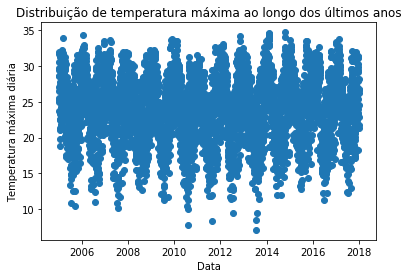

In [0]:
#Visualizando relação dos dados
plt.scatter(dataSet.index, dataSet["TempMaxima"])
plt.title("Distribuição de temperatura máxima ao longo dos últimos anos")
plt.xlabel("Data")
plt.ylabel("Temperatura máxima diária")
plt.show()

# Não parece nada simples, hein? Desafio você a tentar modelar uma função polinomial que descreva o comportamento desse problema. O último ser humano que tentou realizar essa proeza foi encontrado meses depois congelado em uma caverna no Alaska (fonte: FEI - Fatos que Eu Inventei)

In [0]:
#Tornando a informação de mês uma variável do dataSet
dataSet["Mes"] = dataSet.index.month

In [0]:
#Eliminando eventos inconsistentes da base de dados
dataSet = dataSet.dropna()

In [0]:
#Resentando o índice do dataSet
dataSet = dataSet.reset_index(drop = True)

In [0]:
#Visualizando cabeçalho dos dados
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
0,28.6,4.9,3.8,21.62,79.00,2.466667,0.6,18.7,1
1,28.6,10.8,2.2,21.76,73.25,2.566667,0.0,16.6,1
2,26.5,0.3,3.0,20.70,81.75,2.266667,0.0,17.4,1
3,25.3,0.3,1.8,20.20,90.00,1.366667,16.4,17.2,1
4,25.0,0.2,0.7,21.06,91.00,0.533333,17.9,18.2,1


In [0]:
#Visualizando descrição resumida dos dados
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
count,4643.000000,4643.000000,4643.000000,4643.000000,4643.000000,4643.000000,4643.000000,4643.000000,4643.000000
mean,23.861081,5.033427,2.195865,17.877097,80.161857,2.217933,4.485096,14.052660,6.444325
std,4.682767,3.676346,1.317875,3.842865,9.428646,0.782140,10.737399,3.932997,3.422445
min,7.100000,0.000000,0.000000,3.300000,37.750000,0.366667,0.000000,-2.100000,1.000000
25%,20.500000,1.300000,1.200000,15.200000,74.750000,1.700000,0.000000,11.600000,4.000000
50%,24.200000,5.200000,2.000000,18.080000,81.250000,2.133333,0.000000,14.400000,6.000000
75%,27.400000,8.300000,2.900000,20.880000,87.000000,2.633333,2.900000,17.200000,9.000000
max,34.600000,12.600000,11.600000,27.380000,98.750000,6.400000,128.200000,22.400000,12.000000


# Agora vamos separar o que queremos prever (TempMaxima) do restante da base de dados (dataSet)

In [0]:
#Separando "TempMaxima" de dataSet
tempMax = dataSet["TempMaxima"]
dataSet = dataSet.drop(columns = ["TempMaxima"])

In [0]:
#Separando os conjuntos de treino e teste com os dados embaralhados, sendo 80% para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(dataSet, tempMax, test_size = 0.2, random_state = 9)

In [0]:
#Visualizando as dimensões da nossa base de treino (isso será útil mais na frente)
print(X_train.shape)

(3714, 8)


In [0]:
from sklearn.preprocessing import MinMaxScaler
#Aplicando uma transformação que lineariza os dados entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# Agora chegamos no momento esperado: Usar a MLP

In [0]:
from keras.models import Sequential
#Declarando a variável "mlp" como um objeto do tipo "Sequential" (referente às redes de múltiplas camadas) 
mlp = Sequential()

In [0]:
from keras.layers import Dense
#Vamos agora "brincar" de adicionar as camadas
#Adicionando a camada de entrada
mlp.add(Dense(activation = 'tanh', input_dim = 8, units = 8, kernel_initializer = 'random_uniform', bias_initializer='zeros'))
#Adicionando a camada escondida
mlp.add(Dense(activation = 'tanh', units = 8, kernel_initializer = 'random_uniform', bias_initializer='zeros'))
#Adicionando a camada de saída
mlp.add(Dense(units = 1, kernel_initializer = 'random_uniform', bias_initializer='zeros'))
# Compilando o modelo
mlp.compile(loss='mean_squared_error', optimizer = 'adam', metrics= ['mae'])

# Achou um trabalho árduo? Bom, de todo modo, já chegou ao fim. Agora vamos treinar!

In [0]:
#A hora da verdade
mlp.fit(x = X_train, y = y_train, epochs = 400, verbose=1)

Epoch 1/400
3714/3714 [==============================] - 1s 157us/step - loss: 569.7499 - mean_absolute_error: 23.4052
Epoch 2/400
3714/3714 [==============================] - 0s 34us/step - loss: 484.8864 - mean_absolute_error: 21.5148
Epoch 3/400
3714/3714 [==============================] - 0s 38us/step - loss: 422.3636 - mean_absolute_error: 20.0115
Epoch 4/400
3714/3714 [==============================] - 0s 38us/step - loss: 375.4611 - mean_absolute_error: 18.8043
Epoch 5/400
3714/3714 [==============================] - 0s 34us/step - loss: 335.3633 - mean_absolute_error: 17.7049
Epoch 6/400
3714/3714 [==============================] - 0s 34us/step - loss: 299.9974 - mean_absolute_error: 16.6752
Epoch 7/400
3714/3714 [==============================] - 0s 34us/step - loss: 268.3332 - mean_absolute_error: 15.6977
Epoch 8/400
3714/3714 [==============================] - 0s 36us/step - loss: 239.6463 - mean_absolute_error: 14.7589
Epoch 9/400
3714/3714 [==============================] 

In [0]:
#Prevendo os valores de temperatura para o conjunto de teste
y_pred = mlp.predict(X_test)

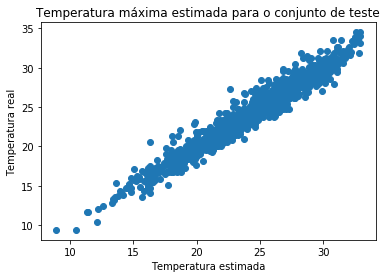

In [0]:
#Vamos primeiro validar o aprendizado graficamente
plt.scatter(y_pred, y_test)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_error
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(y_pred, y_test))

0.8166521452214927


In [0]:
from sklearn.metrics import mean_squared_error
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(y_pred, y_test))

1.1229186701934772
